<a href="https://colab.research.google.com/github/PARULCHUTANIPC/YOLO/blob/YOLO-NAS/YOLO_NAS_Bogie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 01: Installing the Packages

In [1]:
%%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

Restart the Run Time

# Step 02: Importing all the required libraries

In [2]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

The console stream is logged into /root/sg_logs/console.log


[2023-05-07 16:12:15] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-05-07 16:12:23] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-07 16:12:23] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-07 16:12:23] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-07 16:12:23] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [3]:
from IPython.display import clear_output

In [4]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

In [5]:
from super_gradients.training import models

# Step 03: Setting the checkpoint directory and experiment name | Instantiated the trainer

In [33]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='run4', ckpt_root_dir=CHECKPOINT_DIR)

# Step 04: Custom Dataset

In [34]:
dataset_params = {
    'data_dir':'/content/drive/MyDrive/bogie dataset',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'val/images',
    'val_labels_dir':'val/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Bogie']
}

In [35]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

In [36]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [37]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [38]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

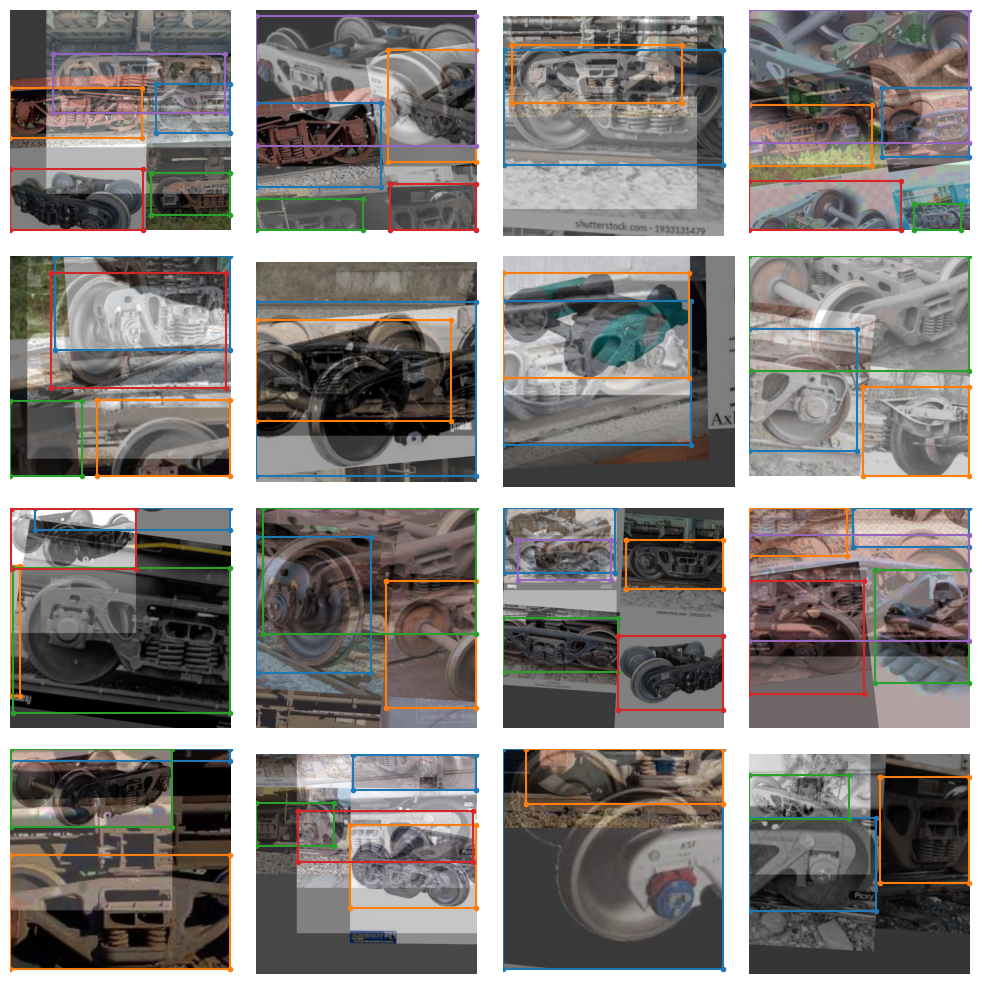

In [39]:
train_data.dataset.plot()

# Step 05: Instantiating the model

In [40]:
from super_gradients.training import models
model = models.get('yolo_nas_m', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

[2023-05-07 16:40:17] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [41]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 40,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# step 06:  Training the model

In [42]:
%cd /content/drive/MyDrive/bogie dataset

In [43]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

/content/drive/MyDrive/bogie dataset


[2023-05-07 16:40:21] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/run4/console_May07_16_40_21.txt


[2023-05-07 16:40:24] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 40         (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         2          (len(train_loader))
    - Gradient updates per epoch:   2          (len(train_loader) / batch_accumulate)

[2023-05-07 16:40:33] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/run4/ckpt_best.pth
[2023-05-07 16:40:33] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0006280478555709124
[2023-05-07 16:40:47] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/run4

SUMMARY OF EPOCH 40
├── Training
│   ├── Ppyoloeloss/loss = 2.1668
│   │   ├── Best until now = 2.1588 (↗ 0.008)
│   │   └── Epoch N-1      = 2.1588 (↗ 0.008)
│   ├── Ppyoloeloss/loss_cls = 1.0323
│   │   ├── Best until now = 1.0306 (↗ 0.0017)
│   │   └── Epoch N-1      = 1.0327 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 1.3279
│   │   ├── Best until now = 1.3252 (↗ 0.0027)
│   │   └── Epoch N-1      = 1.3252 (↗ 0.0027)
│   └── Ppyoloeloss/loss_iou = 0.1882
│       ├── Best until now = 0.1854 (↗ 0.0028)
│       └── Epoch N-1      = 0.1854 (↗ 0.0028)
└── Validation
    ├── F1@0.50 = 0.0167
    │   ├── Best until now = 0.034  (↘ -0.0174)
    │   └── Epoch N-1      = 0.0135 (↗ 0.0032)
    ├── Map@0.50 = 0.6999
    │   ├── Best until now = 0.6444 (↗ 0.0555)
    │   └── Epoch N-1      = 0.6021 (↗ 0.0978)
    ├── Ppyoloeloss/loss = 3.9993
    │   ├── Best until now = 2.8864 (↗ 1.1129)
    │   └── Epoch N-1      = 8.1694 (↘ -4.1701)
    ├── Ppyoloeloss/loss_cls = 2.4378
    │   ├── Best until

# Get the best trained model

In [28]:
best_model = models.get('yolo_nas_m',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/drive/MyDrive/bogie dataset/checkpoints/run3/ckpt_best.pth")
                        #checkpoint_path="checkpoints/my_first_yolonas_run/average_model.pth")

# Step 7 Evaluating the best trained model on the test set

In [29]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  ))

Test: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

{'PPYoloELoss/loss_cls': 5.0366745,
 'PPYoloELoss/loss_iou': 0.38929808,
 'PPYoloELoss/loss_dfl': 1.5446581,
 'PPYoloELoss/loss': 6.7822485,
 'Precision@0.50': tensor(0.0045),
 'Recall@0.50': tensor(0.8000),
 'mAP@0.50': tensor(0.0371),
 'F1@0.50': tensor(0.0089)}

Test: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


# Predicting with the best model

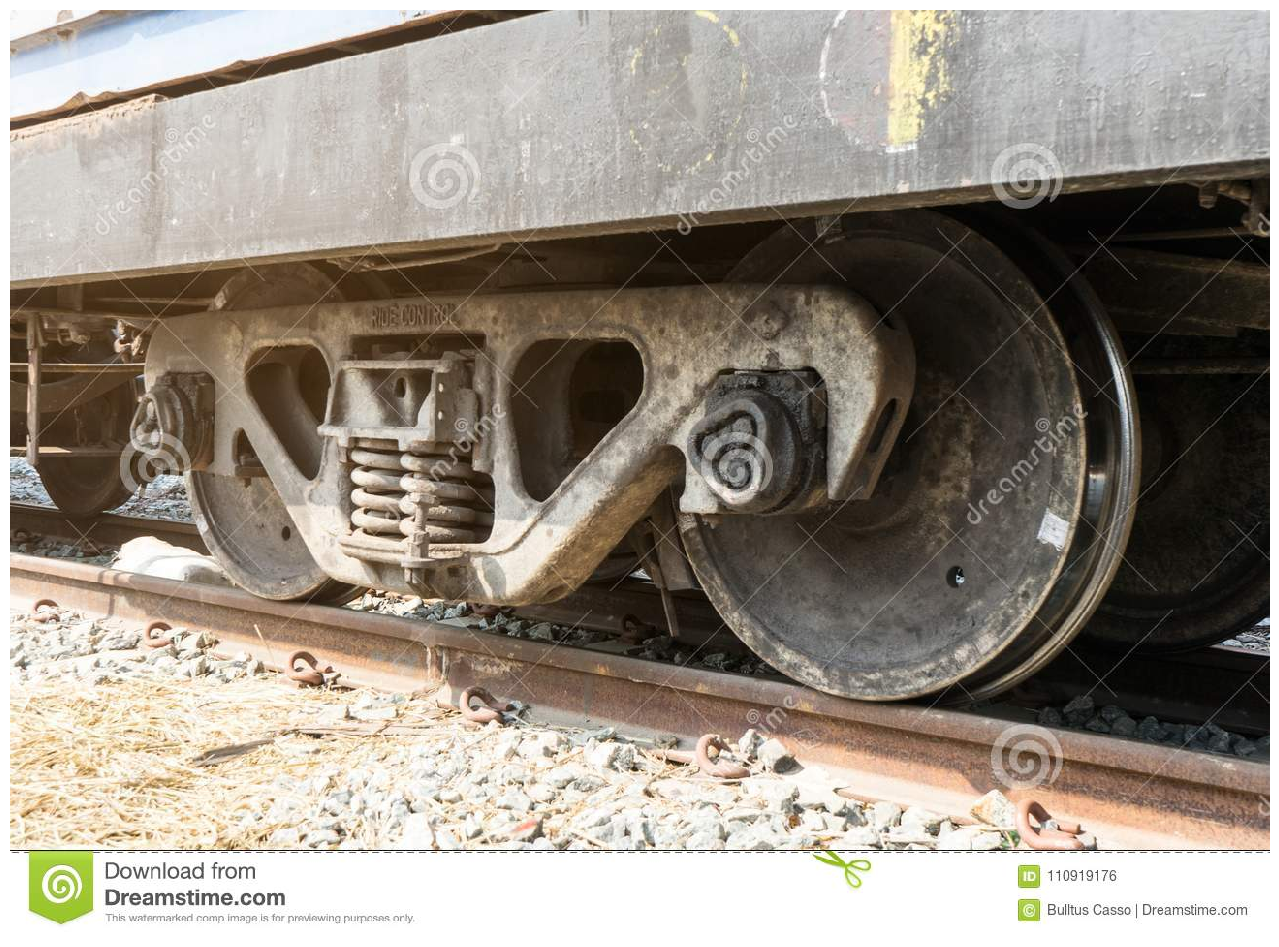

In [30]:
test_image = '/content/bogie test image.jpg'
best_model.predict(test_image).show()